<font size="5">**FoF finds halos and plots the halo mass function**</font>


In [1]:
import numpy as np
import h5py
from scipy.spatial import cKDTree

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
file_path = '/Users/portia/Documents/Research/Cosmology/Halo/Particle_snap/snap_xyz.h5'

In [4]:
with h5py.File(file_path, "r") as file:
    # root group
    print("Content is under the root group:", list(file.keys()))
    # Dataset Name
    print("Dataset Name:", list(file.keys()))
    # Read x, y, z coordinate data
    x = file['x_coords'][:]
    y = file['y_coords'][:]
    z = file['z_coords'][:]

Content is under the root group: ['x_coords', 'y_coords', 'z_coords']
Dataset Name: ['x_coords', 'y_coords', 'z_coords']


In [5]:
# Combine coordinates into a single array
coordinates = np.vstack((x, y, z)).T

In [6]:
# Total number of particles
N = len(coordinates)
print(N)

30687185


In [7]:
# Calculate the coordinate ranges for each axis and the estimated Lbox
axes = {'X': x, 'Y': y, 'Z': z}
for axis_name, data in axes.items():
    d_min, d_max = np.min(data), np.max(data)
    Lbox_estimate = d_max - d_min
    print(f"{axis_name}axis range: {d_min:.2f} to {d_max:.2f}, estimated Lbox = {Lbox_estimate:.2f}")

Xaxis range: 0.00 to 50.00, estimated Lbox = 50.00
Yaxis range: 0.00 to 50.00, estimated Lbox = 50.00
Zaxis range: 0.00 to 50.00, estimated Lbox = 50.00


In [8]:
# Chunk reading
chunk_size = 10000
sample_size = 1000000

with h5py.File(file_path, 'r') as file:
    x = file['x_coords']
    y = file['y_coords']
    z = file['z_coords']
    N = len(x)
    
    indices = np.random.choice(N, size=sample_size, replace=False)
    indices.sort()
    
    sampled_coords = []
    for i in range(0, sample_size, chunk_size):
        chunk = slice(i, min(i + chunk_size, sample_size))
        x_chunk = x[indices[chunk]]
        y_chunk = y[indices[chunk]]
        z_chunk = z[indices[chunk]]
        sampled_coords.append(np.column_stack((x_chunk, y_chunk, z_chunk)))
    
    sampled_coords = np.vstack(sampled_coords)

# Periodic boundary conditions
Lbox = 50.0
sampled_coords = sampled_coords % Lbox

# KD tree calculation of nearest neighbor distances
kdtree = cKDTree(sampled_coords, boxsize=Lbox)

# Query the nearest neighbor distance for each sampled particle (excluding itself)
distances, _ = kdtree.query(sampled_coords, k=2)

# Average spacing
d_mean = np.mean(distances[:, 1])
print(f"Average spacing: {d_mean:.6f}")

Average spacing: 0.130755


In [9]:
# Average spacing estimate of Lbox (uniform distribution)）
Lbox_estimated = d_mean * (N) ** (1/3)
print(f"Estimated Lbox based on average spacing = {Lbox_estimated:.2f}")

Estimated Lbox based on average spacing = 40.94


In [10]:
from halotools.mock_observables import FoFGroups

In [11]:
Lbox = 50.0        
b_perp = 0.2 * d_mean
b_para = 0.2 * d_mean    
nproc = 4

In [12]:
fof_groups = FoFGroups(
    positions = coordinates,
    b_perp = b_perp,
    b_para = b_para,
    period = Lbox,
    num_threads = 4
)

group_ids = fof_groups.group_ids

unique_ids, counts = np.unique(group_ids, return_counts=True)
print(f"Number of unique groups: {len(unique_ids)}")
print("Data processing completed!")

Number of unique groups: 25710216
Data processing completed!


In [13]:
print(f"Group IDs for the first 10000 particles: {group_ids[:10000]}")

Group IDs for the first 10000 particles: [   0    1    2 ... 9046 9054 9055]


In [14]:
print(f"Maximum group size: {np.max(counts)}")
print(f"Minimum group size: {np.min(counts)}")
print(f"Average group size: {np.mean(counts):.2f}")

Maximum group size: 72375
Minimum group size: 1
Average group size: 1.19


In [15]:
# Save group IDs and group size distribution to a file
np.save("group_ids.npy", group_ids)

unique_ids, counts = np.unique(group_ids, return_counts=True)
group_size_distribution = dict(zip(unique_ids, counts))
np.save("group_size_distribution.npy", group_size_distribution)

In [16]:
# Check the number of particles in a specific group
group_size_distribution = np.load("group_size_distribution.npy", allow_pickle=True).item()
group_id = 1234
particle_count = group_size_distribution.get(group_id, "Not found")
print(f"Group ID {group_id} has {particle_count} particles.")

Group ID 1234 has 1 particles.


In [17]:
# Filter out groups with a group size ≥ 20
large_groups = {group_id: count for group_id, count in group_size_distribution.items() if count >= 20}

print("Groups with ≥ 20 particles:")
for group_id, count in large_groups.items():
    print(f"Group ID: {group_id}, Number of particles: {count}")

print(f"Total number of groups with ≥ 20 particles: {len(large_groups)}")

Groups with ≥ 20 particles:
Group ID: 4370, Number of particles: 24
Group ID: 8565, Number of particles: 319
Group ID: 14206, Number of particles: 37
Group ID: 15008, Number of particles: 106
Group ID: 16623, Number of particles: 33
Group ID: 20205, Number of particles: 175
Group ID: 21893, Number of particles: 56
Group ID: 22259, Number of particles: 25
Group ID: 23389, Number of particles: 60
Group ID: 23963, Number of particles: 21
Group ID: 24780, Number of particles: 42
Group ID: 25809, Number of particles: 223
Group ID: 29201, Number of particles: 27
Group ID: 32953, Number of particles: 21
Group ID: 32969, Number of particles: 37
Group ID: 33300, Number of particles: 32
Group ID: 35133, Number of particles: 98
Group ID: 38241, Number of particles: 22
Group ID: 38337, Number of particles: 61
Group ID: 38563, Number of particles: 20
Group ID: 41341, Number of particles: 23
Group ID: 42915, Number of particles: 39
Group ID: 43927, Number of particles: 25
Group ID: 45168, Number of 

In [18]:
print(f"Total number of groups with >= 20 particles: {len(large_groups)}")

Total number of groups with >= 20 particles: 17684


In [19]:
# Total number and proportion of all particles in groups with a size ≥ 20
N_in_large_groups = sum(large_groups.values())
fraction = N_in_large_groups / N
print(f"Total number of particles in groups with ≥ 20 particles: {N_in_large_groups}")
print(f"Fraction of total particles in these groups: {fraction:.4f}")

Total number of particles in groups with ≥ 20 particles: 2124068
Fraction of total particles in these groups: 0.0692


In [20]:
from colossus.cosmology import cosmology
from colossus.lss import mass_function
import numpy as np
import matplotlib.pyplot as plt

In [21]:
# Set cosmological parameters
cosmology.setCosmology('planck18')  # Different cosmological models can be selected, such as 'planck18', 'WMAP9', etc.

In [22]:
# Load data
group_size_distribution = np.load("group_size_distribution.npy", allow_pickle=True).item()

In [24]:
# Filter out halos with a size greater than or equal to 20 particles
large_groups = {group_id: count for group_id, count in group_size_distribution.items() if count >= 20}

# Extract particle count
particle_counts = list(large_groups.values())

# Assume the mass of each particle (unit: h^-1 M_sun)
particle_mass = 8.6e+8  
group_masses = np.array(particle_counts) * particle_mass

In [25]:
# Calculate the mass function
# mfunc = mass_function.massFunction(group_masses, 0.0, mdef='fof', model='watson13')
mfunc_data = mass_function.massFunction(group_masses, 0.0, mdef='fof', model='watson13', q_out='dndlnM')

# Create a mass array for model prediction
mass_model = np.logspace(10, 16, 1000)  # 质量范围从10^10到10^16 h^-1 M_sun
mfunc_model = mass_function.massFunction(mass_model, 0.0, mdef='fof', model='watson13', q_out='dndlnM')

In [26]:
# The mass of each halo with a size ≥ 20 particles
for group_id, count in large_groups.items():
    mass = count * particle_mass
    print(f"Group ID: {group_id}, Number of particles: {count}, Mass: {mass} h^-1 M_sun")

Group ID: 4370, Number of particles: 24, Mass: 20640000000.0 h^-1 M_sun
Group ID: 8565, Number of particles: 319, Mass: 274340000000.0 h^-1 M_sun
Group ID: 14206, Number of particles: 37, Mass: 31820000000.0 h^-1 M_sun
Group ID: 15008, Number of particles: 106, Mass: 91160000000.0 h^-1 M_sun
Group ID: 16623, Number of particles: 33, Mass: 28380000000.0 h^-1 M_sun
Group ID: 20205, Number of particles: 175, Mass: 150500000000.0 h^-1 M_sun
Group ID: 21893, Number of particles: 56, Mass: 48160000000.0 h^-1 M_sun
Group ID: 22259, Number of particles: 25, Mass: 21500000000.0 h^-1 M_sun
Group ID: 23389, Number of particles: 60, Mass: 51600000000.0 h^-1 M_sun
Group ID: 23963, Number of particles: 21, Mass: 18060000000.0 h^-1 M_sun
Group ID: 24780, Number of particles: 42, Mass: 36120000000.0 h^-1 M_sun
Group ID: 25809, Number of particles: 223, Mass: 191780000000.0 h^-1 M_sun
Group ID: 29201, Number of particles: 27, Mass: 23220000000.0 h^-1 M_sun
Group ID: 32953, Number of particles: 21, Mass

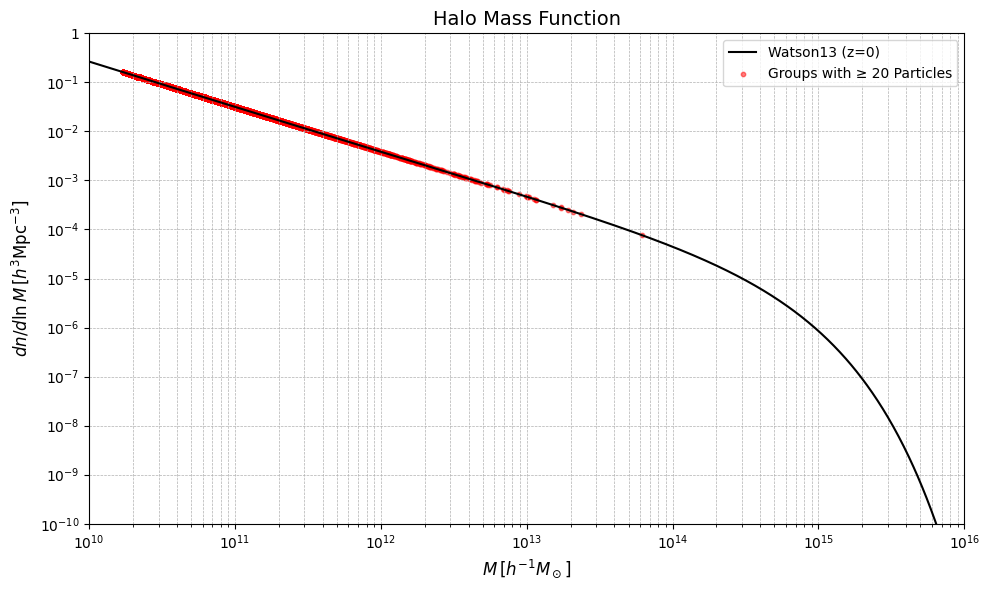

In [27]:
# Plot the graph
plt.figure(figsize=(10, 6))

plt.loglog(mass_model, mfunc_model, 'k-', label='Watson13 (z=0)')
plt.scatter(group_masses, mfunc_data, c='red', s=10, label='Groups with ≥ 20 Particles', alpha=0.5)

plt.xlabel(r'$M \, [h^{-1} M_\odot]$', fontsize=12)
plt.ylabel(r'$dn/d\ln M \, [h^3 \mathrm{Mpc}^{-3}]$', fontsize=12)
plt.title('Halo Mass Function', fontsize=14)

plt.xlim(1e10, 1e16)
plt.ylim(1e-10, 1)

plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()

plt.xticks([1e10, 1e11, 1e12, 1e13, 1e14, 1e15, 1e16], 
           [r'$10^{10}$', r'$10^{11}$', r'$10^{12}$', r'$10^{13}$', r'$10^{14}$', r'$10^{15}$', r'$10^{16}$'])
plt.yticks([1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1],
           [r'$10^{-10}$', r'$10^{-9}$', r'$10^{-8}$', r'$10^{-7}$', r'$10^{-6}$', r'$10^{-5}$', r'$10^{-4}$', r'$10^{-3}$', r'$10^{-2}$', r'$10^{-1}$', '1'])


plt.tight_layout()
plt.show()